In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: US-Mexico border closure was uneffective in preventing importations
Calculating the difference in importation risk into San Diego from Mexico that we observed vs. using a counterfactual of 2019 mobility reveals that the US-Mexico border closure had a very limited effect.

We first load in the inferred infections for each location being analyses. `back-calculated-infections.csv` is generated with the `calculate-infections.R` script.

In [3]:
infections = pd.read_csv( "estimated-importation-risk/back-calculated-infections.csv", parse_dates=["date"] )
infections = infections.loc[infections["population"]!=0]
infections = infections.drop( columns=["Unnamed: 0"])
infections.head()

,date,location,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections
23,2020-02-12,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
24,2020-02-13,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
25,2020-02-14,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
26,2020-02-15,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
27,2020-02-16,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0


We next load mobility data from SafeGraph that has been prepared as in Zeller et al. 2020. As described in figureX_mobility-into-san-diego.ipynb we corrected an artifact we observed in the international mobility data. We also interpolate daily traveler counts from the weekly counts provided by SafeGraph.

Finally, we also add a counterfactual were the number of travelers from 2020 onwards is held at 2019 levels.

In [11]:
def fill_visitors( entry, smooth=True ):
    first = entry.iloc[0]
    entry = entry.set_index( "date_range_start" )
    entry = entry.reindex( pd.date_range( entry.index.min(), entry.index.max() ) )
    entry["week"] = entry.index.map( lambda x: Week.fromdate(x).startdate() )
    entry["true_visitor_count"] = entry.groupby( "week")["true_visitor_count"].transform( lambda x: x.sum() / 7 )
    entry["corrected_visitor_count"]  = entry.groupby( "week" )["corrected_visitor_count"].transform( lambda x: x.sum() / 7 )
    if smooth:
        entry["true_visitor_count"] = entry["true_visitor_count"].rolling( 7, min_periods=1 ).mean()
        entry["corrected_visitor_count"] = entry["corrected_visitor_count"].rolling( 7, min_periods=1 ).mean()
    entry["location"] = first["location"]
    return entry.reset_index()

def correct_mobility( entry ):
    start = "2019-03-01"
    end = "2019-12-29"

    return_df = entry.copy()
    mean2019 = entry.loc[entry["date_range_start"] < start,"true_visitor_count"].mean()
    mean2020 = entry.loc[entry["date_range_start"].between( end, "2020-03-01"),"true_visitor_count"].mean()
    ratio = mean2019 / mean2020

    return_df["corrected_visitor_count"] = return_df["true_visitor_count"]
    if (mean2019 == 0) or (mean2020 == 0):
        return return_df

    return_df.loc[entry["date_range_start"] > end, "corrected_visitor_count"] = return_df["true_visitor_count"] * ratio
    return return_df

def add_counter_travelers( entry ):
    entry["counter_travelers"] = entry["corrected_visitor_count"]
    entry.loc[entry["index"] > "2020-01-07","counter_travelers"] = entry["corrected_visitor_count"].shift( 365 )
    entry.loc[entry["index"] > "2021-01-07","counter_travelers"] = entry["corrected_visitor_count"].shift( 730 )
    return entry

st = pd.read_csv( "../data/mobility_states.csv", parse_dates=["date_range_start"] )
st = st.drop( columns=["California"] )
st = st.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

cr = pd.read_csv("../data/mobility_countries.csv", parse_dates=["date_range_start"] )
cr = cr.drop( columns=["Georgia", "United States"] )
cr = cr.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

ca = pd.read_csv( "../data/mobility_ca-counties.csv", parse_dates=["date_range_start"] )
ca = ca.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

mob = pd.concat( [st, cr, ca] )
mob = mob.groupby( "location" ).apply( correct_mobility ).reset_index( drop=True )
mob = mob.groupby( "location" ).apply( fill_visitors ).reset_index( drop=True )
mob = mob.groupby( "location" ).apply( add_counter_travelers ).reset_index( drop=True )

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_88980/3968076454.py:21: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_88980/3968076454.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = mean2019 / mean2020


Merge mobility and infections dataset. Removing locations without either travelers or infections.

In [13]:
mob = mob.merge( infections, left_on=["location", "index"], right_on=["location", "date"], how="left" )
mob.loc[mob["index"].isna(),"index"] = mob["date"]
mob = mob.drop( columns=["date"] )
mob = mob.rename( columns={"index" : "date"} )
mob["population"] = mob.groupby( "location" )["population"].transform( "max" )

empty_locations = np.setdiff1d( mob.location.unique(), infections["location"].unique() )
mob = mob.loc[~mob["location"].isin(empty_locations)]

mob.head()

,date,location,true_visitor_count,corrected_visitor_count,week,counter_travelers,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections
0,2019-01-07,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
1,2019-01-08,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
2,2019-01-09,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
3,2019-01-10,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
4,2019-01-11,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN


We calculate estimated infection rate as the sum of travellers that arrived from each location and the infection rate at that location.

In [14]:
mob = mob.fillna( 0.0 )
mob["estimated_infections"] = mob["estimated_infections"] / mob["population"]
mob["cases"] = mob["cases"] / mob["population"]
mob["eii_mean"] = mob["estimated_infections"] * mob["corrected_visitor_count"]
mob["eii_counter"] = mob["estimated_infections"] * mob["counter_travelers"]
mob.head()

,date,location,true_visitor_count,corrected_visitor_count,week,counter_travelers,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections,eii_mean,eii_counter
0,2019-01-07,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
1,2019-01-08,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
2,2019-01-09,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
3,2019-01-10,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
4,2019-01-11,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0


We calculate the percent change in absolute importation risk from Mexico if there was no reduction in travel relative to 2019 levels.

In [31]:
eii_difference = mob.groupby( "location" )[["eii_mean", "eii_counter"]].sum()
eii_difference["diff"] = eii_difference["eii_counter"] / eii_difference["eii_mean"]
eii_difference["eii_mean_relative"] = eii_difference["eii_mean"] / eii_difference["eii_mean"].sum()
eii_difference.loc["Mexico","eii_mean"] = eii_difference.loc["Mexico","eii_counter"]
eii_difference["eii_mean_relative_mx"] = eii_difference["eii_mean"] / eii_difference["eii_mean"].sum()

#eii_difference["eii_counter_relative"] = eii_difference["eii_counter"] / eii_difference["eii_counter"].sum()
#eii_difference["diff_relative"] =  eii_difference["eii_counter_relative"] - eii_difference["eii_mean_relative"]
#eii_difference.sort_values( "diff_relative" )

print( f"Total absolute increase in importation risk from Mexico: {eii_difference.loc['Mexico','diff']-1:.1%}" )
print( f"Change in relative importation risk from Mexico: {eii_difference.loc['Mexico','eii_mean_relative_mx']-eii_difference.loc['Mexico','eii_mean_relative']:.1%}" )

Total absolute increase in importation risk from Mexico: 29.6%
Change in relative importation risk from Mexico: 2.7%


To contextualize how big of any effect this increase would have, we calculate the change in relative importation risk.

In [61]:
counter_mx = mob.pivot( index="date", columns="location", values=["eii_mean","eii_counter"] )
counter_mx["month"] = pd.to_datetime( counter_mx.index.strftime('%Y-%m-01' ) )
counter_mx = counter_mx.reset_index( drop=True ).groupby( "month" ).sum()

# Just replace mexico eii.
observed = counter_mx["eii_mean"].copy()
counter_mx["eii_mean"]["Mexico"] = counter_mx["eii_counter"]["Mexico"]
counter_all = counter_mx["eii_counter"]
counter_mx = counter_mx["eii_mean"]

observed = observed.apply( lambda x: x/x.sum(), axis=1 )
counter_mx = counter_mx.apply( lambda x: x/x.sum(), axis=1 )
counter_all = counter_all.apply( lambda x: x/x.sum(), axis=1 )

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_88980/144734671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counter_mx["eii_mean"]["Mexico"] = counter_mx["eii_counter"]["Mexico"]


Here we plot the monthly change in relative import risk in the counterfactual situation were only mobility from mexico is held constant at 2019 levels.

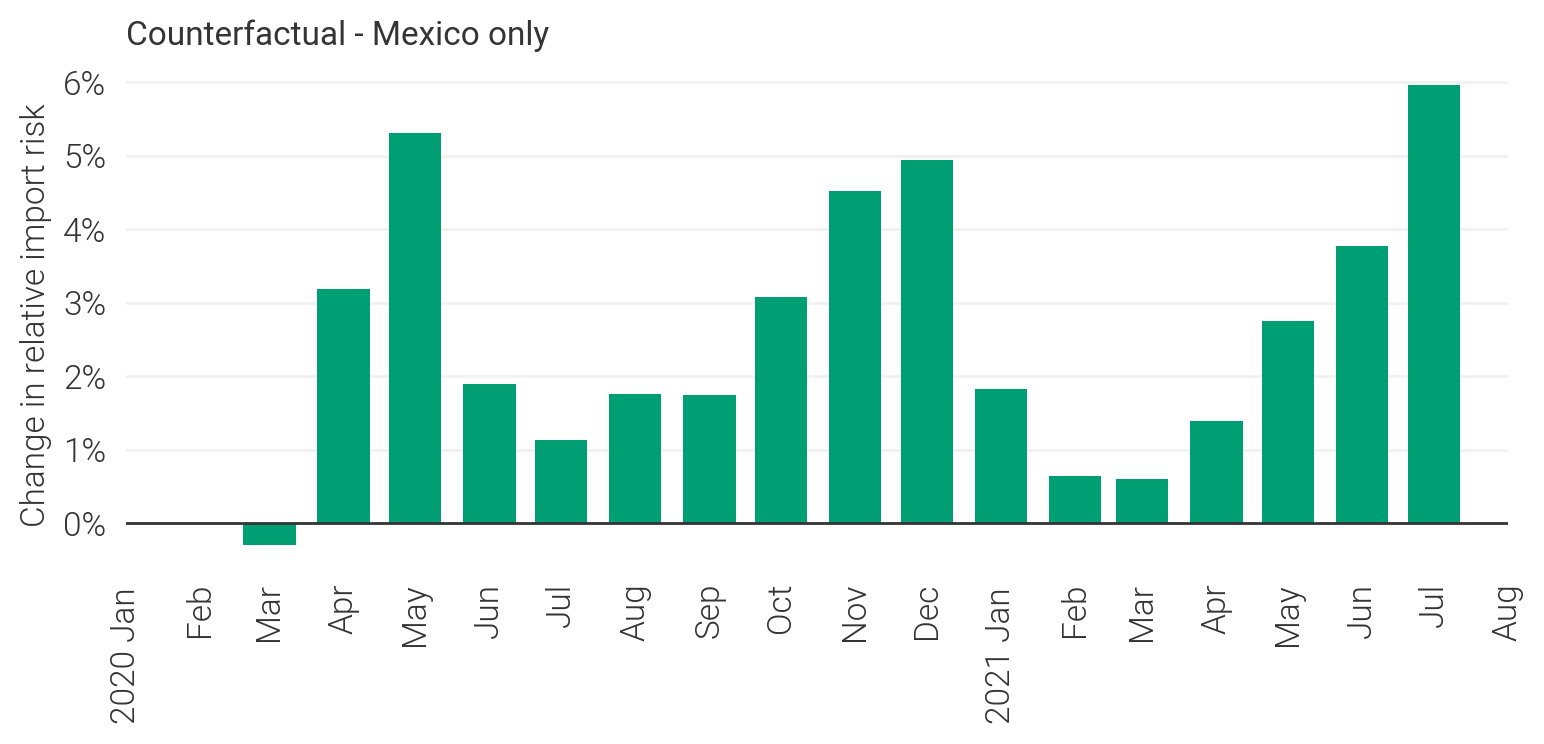

In [74]:
plot_df = pd.merge( observed, counter_mx, left_index=True, right_index=True, suffixes=["_normal", "_counter"] )

fig, ax = plt.subplots( dpi=200, figsize=(8,4) )
ax.bar( x=plot_df.index, height=plot_df["Mexico_counter"] - plot_df["Mexico_normal"], color="#009E73", width=22, zorder=10, align="center" )
basic_formatting( ax, spines=[], ylabel="Change in relative import risk", xlims=(pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01" )) )
timeseries_formatting( ax )

ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0 ) )
ax.axhline( 0, color=COLOR, linewidth=1, zorder=11 )
ax.set_title( "Counterfactual - Mexico only", loc="left", fontsize=12)

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_import-risk-counterfactual-mexico.pdf" )
plt.show()

Here we plot the monthly change in relative import risk in the counterfactual situation were mobility all locations is held constant at 2019 levels.

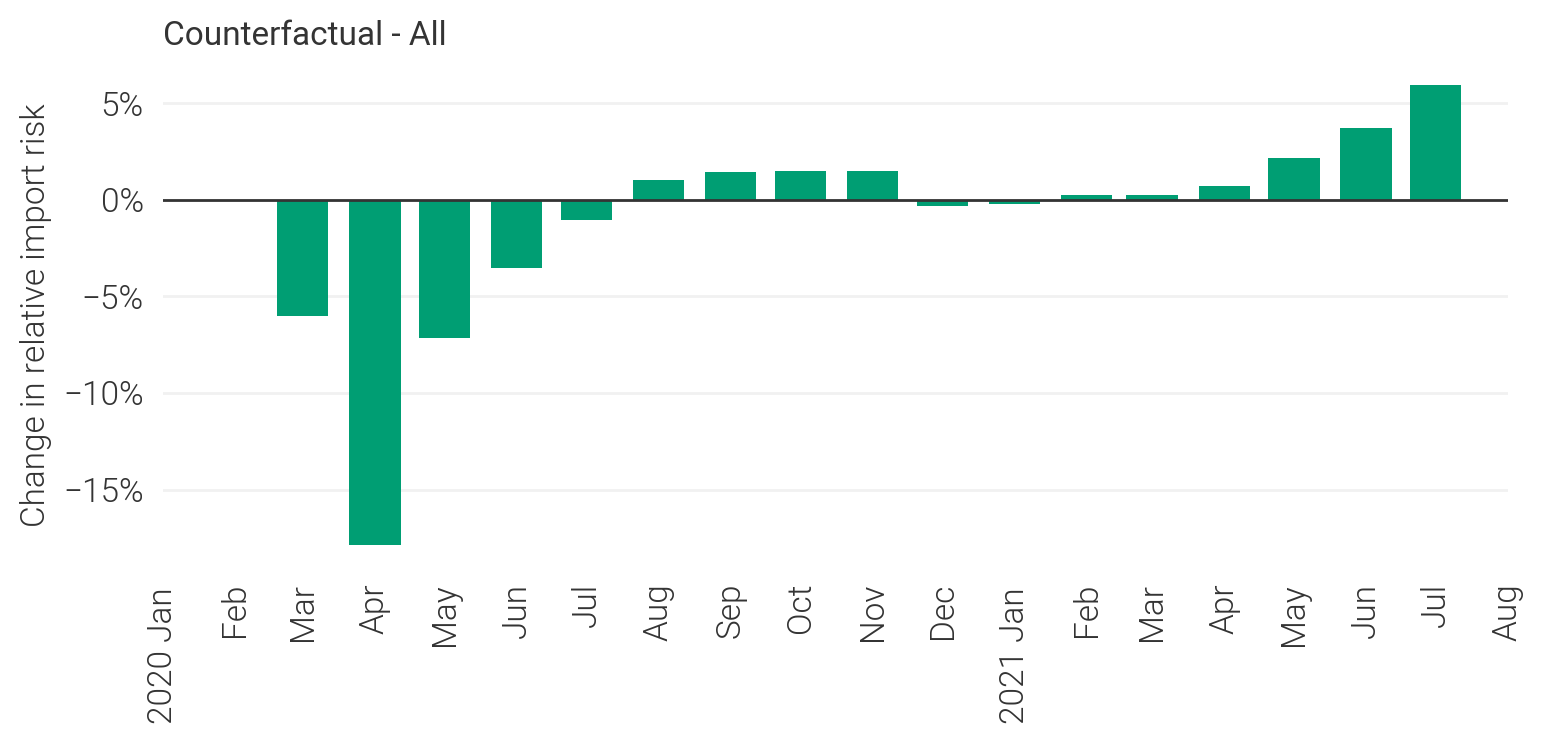

In [75]:
plot_df = pd.merge( observed, counter_all, left_index=True, right_index=True, suffixes=["_normal", "_counter"] )

fig, ax = plt.subplots( dpi=200, figsize=(8,4) )
ax.bar( x=plot_df.index, height=plot_df["Mexico_counter"] - plot_df["Mexico_normal"], color="#009E73", width=22, zorder=10, align="center" )
basic_formatting( ax, spines=[], ylabel="Change in relative import risk", xlims=(pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01" )) )
timeseries_formatting( ax )

ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0 ) )
ax.axhline( 0, color=COLOR, linewidth=1, zorder=11 )
ax.set_title( "Counterfactual - All", loc="left", fontsize=12 )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_import-risk-counterfactual-all.pdf" )
plt.show()